# Clasificación de Hojas de Café

### Cargar las anotaciones del dataset

In [1]:
import json

annotations_file="RoCoLe.json"

with open(annotations_file,'r') as f:
    annotations=json.load(f)

### Dimensión del dataset

In [2]:
len(annotations)

1560

### Esquema de las anotaciones

In [3]:
annotations[1]

{'ID': 'cjvnf878wfzzd0838svwmv6gu',
 'DataRow ID': 'cjvnehagg0jhv0ctne7uze0m7',
 'Labeled Data': 'https://storage.googleapis.com/labelbox-193903.appspot.com/cjs5g735orqbe0b29ip8a1k1s%2F24a51d91-3220-414f-479b-4182739c011c-C1P2E2.jpg',
 'Label': {'Leaf': [{'state': 'unhealthy',
    'geometry': [{'x': 105, 'y': 526},
     {'x': 213, 'y': 547},
     {'x': 357, 'y': 496},
     {'x': 518, 'y': 446},
     {'x': 718, 'y': 416},
     {'x': 911, 'y': 420},
     {'x': 1088, 'y': 420},
     {'x': 1185, 'y': 446},
     {'x': 1323, 'y': 471},
     {'x': 1396, 'y': 531},
     {'x': 1468, 'y': 586},
     {'x': 1539, 'y': 618},
     {'x': 1523, 'y': 632},
     {'x': 1488, 'y': 632},
     {'x': 1442, 'y': 643},
     {'x': 1415, 'y': 680},
     {'x': 1383, 'y': 719},
     {'x': 1341, 'y': 767},
     {'x': 1277, 'y': 804},
     {'x': 1180, 'y': 822},
     {'x': 1125, 'y': 864},
     {'x': 1026, 'y': 875},
     {'x': 895, 'y': 859},
     {'x': 794, 'y': 845},
     {'x': 672, 'y': 815},
     {'x': 610, 'y'

### Crear una clase que contenga la información de las hojas

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from IPython.display import display, Markdown


class CoffeeLeaf:    
    def __init__(self, leaf_id, state, classification, image_bgr, geometry):
        self.id = leaf_id
        self.state_manual = state
        self.state_computed = None
        self.classification_manual = classification
        self.classification_computed = None
        self.image_bgr = image_bgr
        self.image_rgb = None
        self.roi_rgb = None
        self.roi_hsv = None
        self.masked_roi_rgb = None
        self.masked_roi_hue = None
        self.mask = None
        self.area = None
        self.affected_percentage = None
        self.histogram_hue = None
        self.limit_below = None
        self.limit_above = None
        self.binary = None
        self.contours = None
        self.contours_canvas = None
        self.polygon = None
        self.geometry = geometry
        self._processed = False

    def _generate_image_rgb(self):
        self.image_rgb = cv.cvtColor(self.image_bgr, cv.COLOR_BGR2RGB)

    def _create_polygon(self):
        polygon_points = [list(point.values()) for point in self.geometry]
        self.polygon = np.array(polygon_points)

    def _create_roi(self):
        x,y,w,h = cv.boundingRect(self.polygon)
        self.roi_rgb = self.image_rgb[y:y+h, x:x+w].copy()
        self.roi_hsv = cv.cvtColor(self.roi_rgb, cv.COLOR_RGB2HSV)

    def _create_mask(self):
        self.mask = np.zeros(self.roi_hsv.shape[:2], np.uint8)
        polygon_start = self.polygon.min(axis=0)
        polygon_at_zero = self.polygon-polygon_start
        CONTOURS = -1 # All contours
        COLOR = (255, 255, 255) # White
        THICKNESS = -1 # Fill
        self.mask = cv.drawContours(self.mask, [polygon_at_zero], CONTOURS, COLOR, THICKNESS)
        self.area = cv.countNonZero(self.mask)

    def _create_masked_roi(self):
        self.masked_roi_rgb = cv.bitwise_and(self.roi_rgb, self.roi_rgb, mask=self.mask)
        self.masked_roi_hue = cv.bitwise_and(self.roi_hsv[:,:,0], self.mask)

    def _compute_histogram(self):
        hsv_normalizer = Normalize(vmin=0, vmax=179)
        self.hsv_mappable = ScalarMappable(norm=hsv_normalizer, cmap='hsv')
        self.histogram_hue = cv.calcHist([self.masked_roi_hue], [0], self.mask, [180], [0,180])

    def _binarize(self):
        GREEN_LIMIT_BELOW = 30
        GREEN_LIMIT_ABOVE = 120
        _, segments_below_green = cv.threshold(self.masked_roi_hue, GREEN_LIMIT_BELOW, 179, cv.THRESH_BINARY)
        _, segments_above_green = cv.threshold(self.masked_roi_hue, GREEN_LIMIT_ABOVE, 179, cv.THRESH_BINARY_INV)
        self.binary = cv.bitwise_and(segments_below_green, segments_above_green)

    def _erode_and_dilate(self):
        """
        Erode N times to erase smallest holes/contours
        Also consider to use a line/rectangle mask to erase leaf skeleton
        Dilate N times to recover holes/contours
        """
        # Not required -> information loss
        pass

    def _find_contours(self):
        self.contours, _ = cv.findContours(self.binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    def _filter_contours(self):
        valid_contours = []
        for contour in self.contours:
            contour_area = cv.contourArea(contour)
            contour_area_percentage = (contour_area/self.area)*100
            if contour_area_percentage < 50 and contour_area_percentage > 0.01:
                valid_contours.append(contour)
        self.contours = valid_contours

    def _draw_contours(self):
        CONTOURS = -1 # All contours
        COLOR = (255, 255, 255) # White
        THICKNESS = -1 # Fill
        self.contours_canvas = np.zeros(self.mask.shape, np.uint8)
        cv.drawContours(self.contours_canvas, self.contours, CONTOURS, COLOR, THICKNESS)

    def _categorize(self):
        healthy_area = cv.countNonZero(self.binary)
        affected_area = self.area-healthy_area
        self.affected_percentage = int((affected_area/self.area)*100)
        if self.affected_percentage < 1:
            self.state_computed = "healthy"
            self.classification_computed = "healthy"
        elif self.affected_percentage < 6:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_1"
        elif self.affected_percentage < 21:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_2"
        elif self.affected_percentage < 51:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_3"
        else:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_4"

    def show_summary(self):
        original_class = self.classification_manual
        new_class = self.classification_computed
        affected_area = self.affected_percentage
        title_md = f"### {original_class} --> {new_class} ({affected_area} %)"
        display(Markdown(title_md))

    def show_original_image(self):
        plt.imshow(self.image_rgb)
        plt.title("Imagen Original")
        plt.axis("off")
        plt.show()

    def show_mask(self):
        plt.imshow(self.mask, cmap='gray')
        plt.title("Máscara")
        plt.axis("off")
        plt.show()

    def show_roi(self, hue=False):
        if hue:
            colorspace = "Hue"
            plt.imshow(self.masked_roi_hue, cmap='hsv')
        else:
            colorspace = "RGB"
            plt.imshow(self.masked_roi_rgb)
        plt.title(f"Región de Interés ({colorspace})")
        plt.axis("off")
        plt.show()

    def show_binary(self):
        plt.imshow(self.binary, cmap='gray')
        plt.title(f"Segmentación")
        plt.axis("off")
        plt.show()

    def show_contours(self):
        plt.imshow(self.contours_canvas, cmap='gray')
        plt.title(f"Contornos")
        plt.axis("off")
        plt.show()

    def show_histogram(self):
        fig, ax = plt.subplots()
        ax.plot(self.histogram_hue)
        colorbar = plt.colorbar(self.hsv_mappable, ax=ax, location='bottom')
        colorbar.set_ticks([])
        idx_max = np.argmax(self.histogram_hue)
        plt.title(f"Histograma (Hue) Máx={idx_max}")
        plt.margins(x=0)
        plt.show()

    def process(self):
        self._generate_image_rgb()
        self._create_polygon()
        self._create_roi()
        self._create_mask()
        self._create_masked_roi()
        self._compute_histogram()
        self._binarize()
        self._categorize()
        self._processed = True

    def describe(self):
        if not self._processed:
            print("Imagen aún no procesada")
            return
        self.show_summary()
        self.show_original_image()
        self.show_mask()
        self.show_roi()
        self.show_roi(hue=True)
        self.show_binary()
        self.show_histogram()

### Cargar las imágenes del dataset en objetos CoffeeLeaf

In [5]:
IMAGES_PATH = "../rocole_photos/"

coffee_leaves = []

for annotation in annotations:
    classification = annotation["Label"]["classification"]
    if classification != "red_spider_mite":
        leaf_id = annotation["ID"]
        state = annotation["Label"]["Leaf"][0]["state"]
        geometry = annotation["Label"]["Leaf"][0]["geometry"]
        leaf_image = f"{IMAGES_PATH}/{leaf_id}.jpeg"
        image_bgr = cv.imread(leaf_image)
        coffee_leaf = CoffeeLeaf(leaf_id, state, classification, image_bgr, geometry)
        coffee_leaves.append(coffee_leaf)

## Procesar las imágenes

In [6]:
for coffee_leaf in coffee_leaves:
    coffee_leaf.process()

## Resultados

In [7]:
coffee_leaves_state_correct = []
coffee_leaves_state_incorrect = []
coffee_leaves_class_correct = []
coffee_leaves_class_incorrect = []

original_healthy = []
original_rust_level_1 = []
original_rust_level_2 = []
original_rust_level_3 = []
original_rust_level_4 = []

new_healthy = []
new_rust_level_1 = []
new_rust_level_2 = []
new_rust_level_3 = []
new_rust_level_4 = []

for coffee_leaf in coffee_leaves:
    # Original classes
    if coffee_leaf.classification_manual == "rust_level_1":
        original_rust_level_1.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_2":
        original_rust_level_2.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_3":
        original_rust_level_3.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_4":
        original_rust_level_4.append(coffee_leaf)
    else:
        original_healthy.append(coffee_leaf)
    
    # New classes
    if coffee_leaf.classification_computed == "rust_level_1":
        new_rust_level_1.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_2":
        new_rust_level_2.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_3":
        new_rust_level_3.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_4":
        new_rust_level_4.append(coffee_leaf)
    else:
        new_healthy.append(coffee_leaf)

    # Total Hits for State
    if coffee_leaf.state_computed == coffee_leaf.state_manual:
        coffee_leaves_state_correct.append(coffee_leaf)
    else:
        coffee_leaves_state_incorrect.append(coffee_leaf)
    # Total Hits for Class
    if coffee_leaf.classification_computed == coffee_leaf.classification_manual:
        coffee_leaves_class_correct.append(coffee_leaf)
    else:
        coffee_leaves_class_incorrect.append(coffee_leaf)

# Hits per class
new_healthy_correct = [leaf for leaf in new_healthy
                       if leaf.classification_computed == leaf.classification_manual]
new_rust_level_1_correct = [leaf for leaf in new_rust_level_1
                            if leaf.classification_computed == leaf.classification_manual]
new_rust_level_2_correct = [leaf for leaf in new_rust_level_2
                            if leaf.classification_computed == leaf.classification_manual]
new_rust_level_3_correct = [leaf for leaf in new_rust_level_3
                            if leaf.classification_computed == leaf.classification_manual]
new_rust_level_4_correct = [leaf for leaf in new_rust_level_4
                            if leaf.classification_computed == leaf.classification_manual]

# Total processed
total = len(coffee_leaves)

# Global Accuracy for State
hits_state = len(coffee_leaves_state_correct)
misses_state = len(coffee_leaves_state_incorrect)
accuracy_state = (hits_state/total)*100

# Global Accuracy for Class
hits_class = len(coffee_leaves_class_correct)
misses_class = len(coffee_leaves_class_incorrect)
accuracy_class = (hits_class/total)*100

original_h = len(original_healthy)
original_r1 = len(original_rust_level_1)
original_r2 = len(original_rust_level_2)
original_r3 = len(original_rust_level_3)
original_r4 = len(original_rust_level_4)

new_h = len(new_healthy_correct)
new_r1 = len(new_rust_level_1_correct)
new_r2 = len(new_rust_level_2_correct)
new_r3 = len(new_rust_level_3_correct)
new_r4 = len(new_rust_level_4_correct)

accuracy_h = (new_h/original_h)*100
accuracy_r1 = (new_r1/original_r1)*100
accuracy_r2 = (new_r2/original_r2)*100
accuracy_r3 = (new_r3/original_r3)*100
accuracy_r4 = (new_r4/original_r4)*100

In [8]:
print("Global accuracy for State\n")
print(f"Total = {total}")
print(f"Aciertos = {hits_state}")
print(f"Errores = {misses_state}")
print(f"Precisión = {accuracy_state} %")

print("\nGlobal accuracy for Class\n")
print(f"Total = {total}")
print(f"Aciertos = {hits_class}")
print(f"Errores = {misses_class}")
print(f"Precisión = {accuracy_class} %")

print("\nAccuracy per Class\n")

print("ORIGINAL:")
print(f"healthy: {original_h}")
print(f"rust_level_1: {original_r1}")
print(f"rust_level_2: {original_r2}")
print(f"rust_level_3: {original_r3}")
print(f"rust_level_4: {original_r4}")

print("\nCOMPUTED:")
print(f"healthy: {new_h}")
print(f"rust_level_1: {new_r1}")
print(f"rust_level_2: {new_r2}")
print(f"rust_level_3: {new_r3}")
print(f"rust_level_4: {new_r4}")

print("\nACCURACY:")
print(f"healthy: {accuracy_h} %")
print(f"rust_level_1: {accuracy_r1} %")
print(f"rust_level_2: {accuracy_r2} %")
print(f"rust_level_3: {accuracy_r3} %")
print(f"rust_level_4: {accuracy_r4} %")

Global accuracy for State

Total = 1393
Aciertos = 962
Errores = 431
Precisión = 69.05958363244795 %

Global accuracy for Class

Total = 1393
Aciertos = 715
Errores = 678
Precisión = 51.32806891600862 %

Accuracy per Class

ORIGINAL:
healthy: 791
rust_level_1: 344
rust_level_2: 166
rust_level_3: 62
rust_level_4: 30

COMPUTED:
healthy: 445
rust_level_1: 196
rust_level_2: 67
rust_level_3: 6
rust_level_4: 1

ACCURACY:
healthy: 56.25790139064475 %
rust_level_1: 56.97674418604651 %
rust_level_2: 40.36144578313253 %
rust_level_3: 9.67741935483871 %
rust_level_4: 3.3333333333333335 %


### Eficiencia global respecto al estado de las hojas (saludable/infectada)

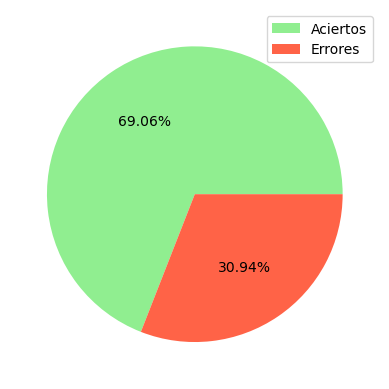

In [9]:
results = [hits_state, misses_state]
labels = ['Aciertos', 'Errores']
colors = ['lightgreen', 'tomato']

plt.pie(results, colors=colors, autopct='%1.2f%%')
plt.legend(labels)
plt.show()

### Eficiencia global respecto a la clasificación de las hojas (nivel de afectación)

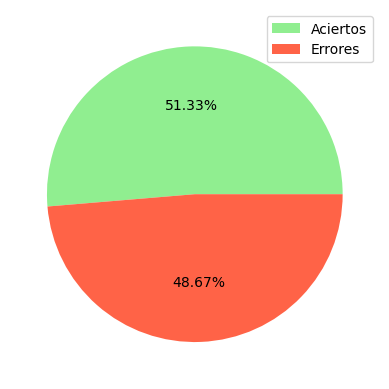

In [10]:
results = [hits_class, misses_class]
labels = ['Aciertos', 'Errores']
colors = ['lightgreen', 'tomato']

plt.pie(results, colors=colors, autopct='%1.2f%%')
plt.legend(labels)
plt.show()

### Eficiencia individual respecto a la clasificación de las hojas (nivel de afectación)

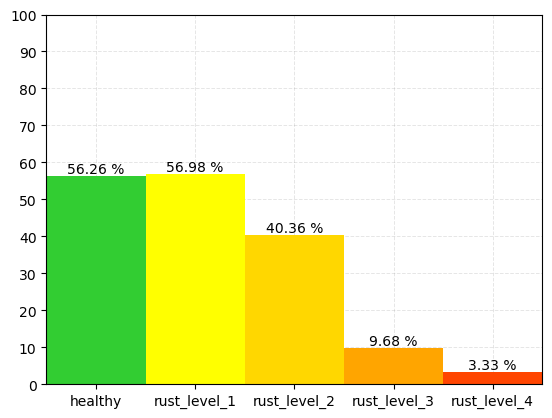

In [11]:
classifications = ['healthy', 'rust_level_1', 'rust_level_2', 'rust_level_3', 'rust_level_4']
accuracies = [accuracy_h, accuracy_r1, accuracy_r2, accuracy_r3, accuracy_r4]
colors = ['limegreen', 'yellow', 'gold', 'orange', 'orangered']

fig, ax = plt.subplots()
bars = ax.bar(classifications, accuracies, width=1.0, color=colors, zorder=2)
ax.grid(True, color='gray', linestyle='--', linewidth=0.7, zorder=1, alpha=0.2)
ax.bar_label(bars, fmt='%.2f %%')
plt.yticks(np.arange(0, 101, step=10))
plt.margins(x=0, y=0)
plt.ylim(0, 100)
plt.show()

## Discrepancias

### rust_level_3 --> rust_level_2 (10 %)

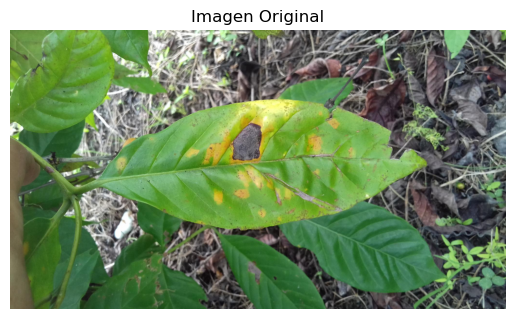

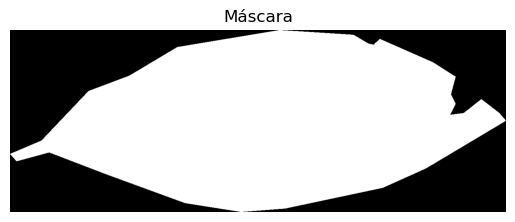

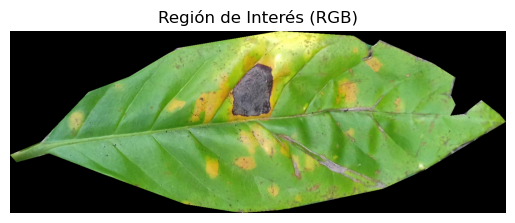

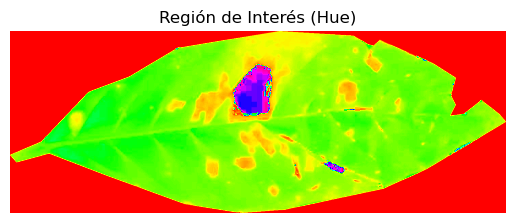

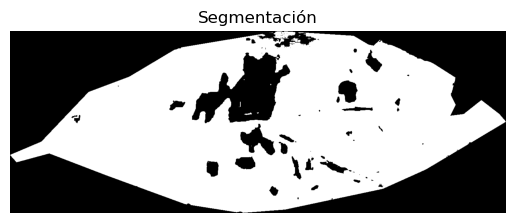

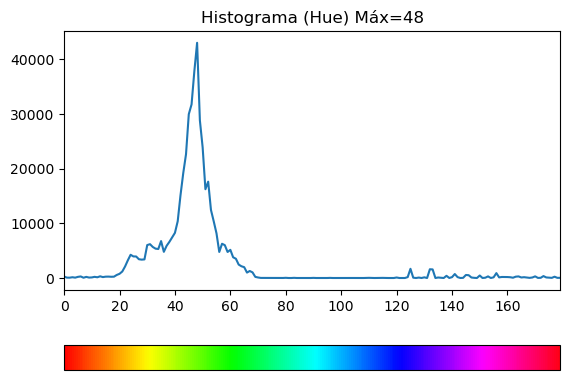

### rust_level_2 --> rust_level_1 (3 %)

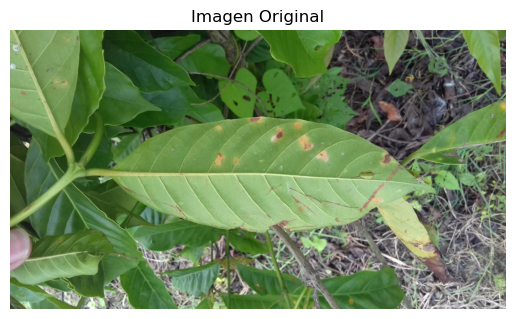

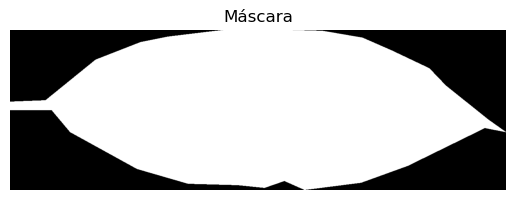

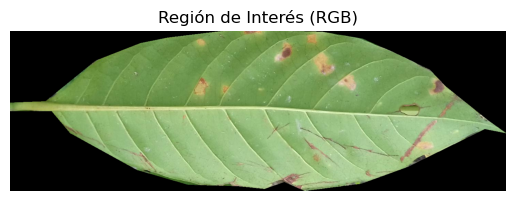

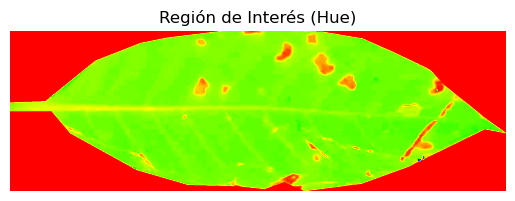

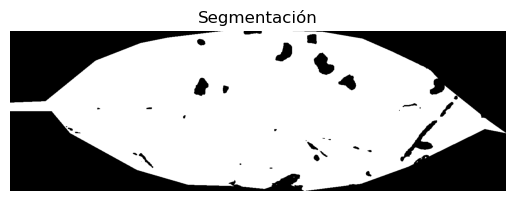

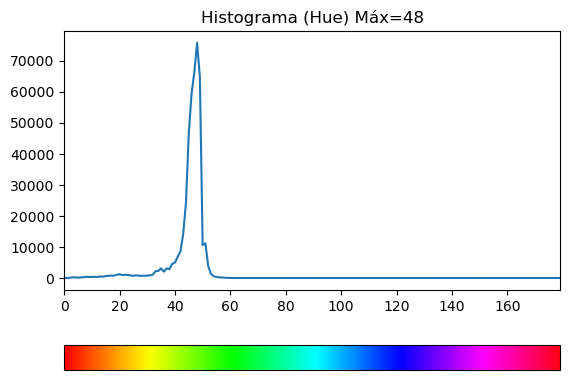

### rust_level_2 --> rust_level_1 (2 %)

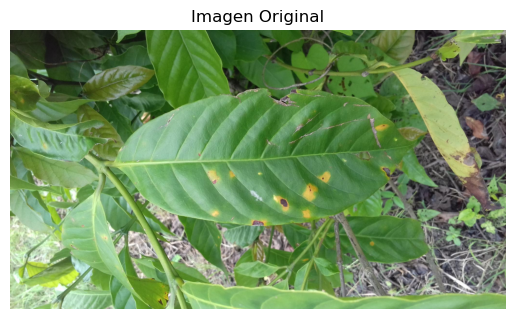

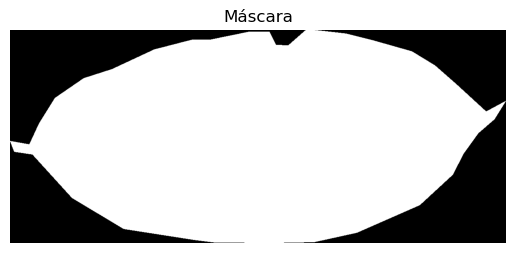

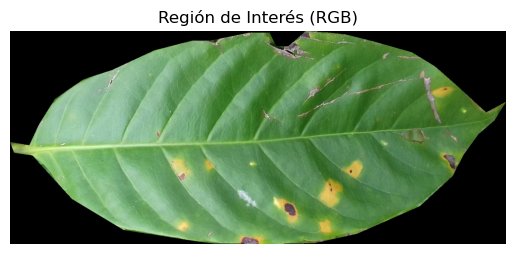

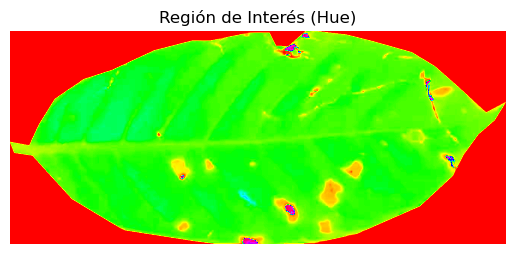

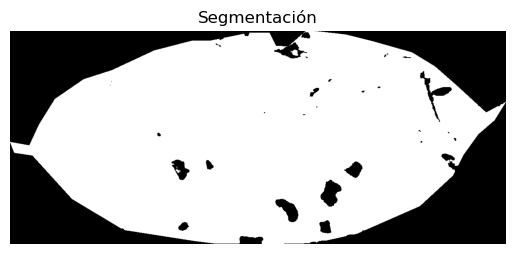

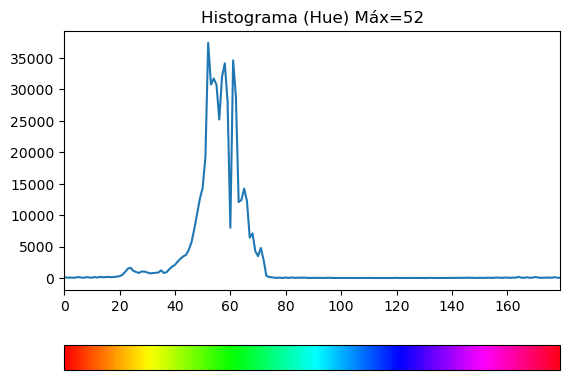

### healthy --> rust_level_1 (3 %)

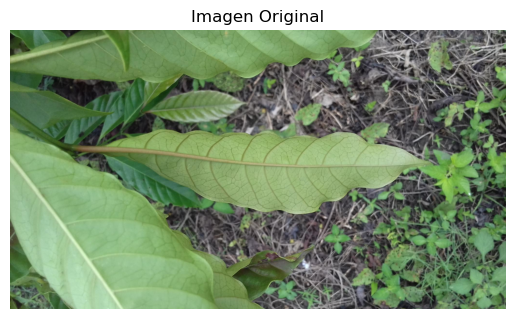

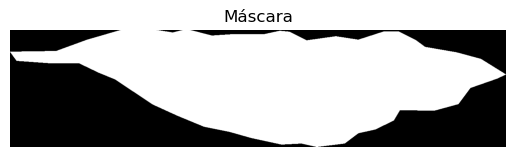

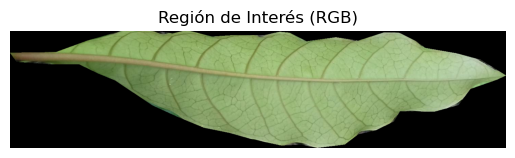

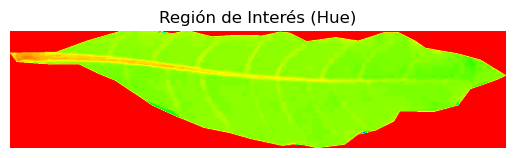

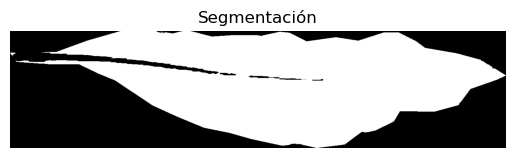

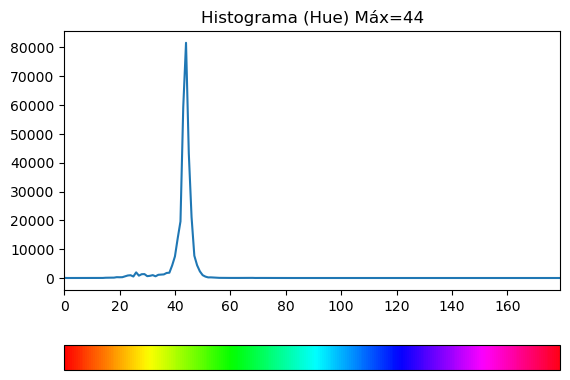

### rust_level_2 --> rust_level_1 (2 %)

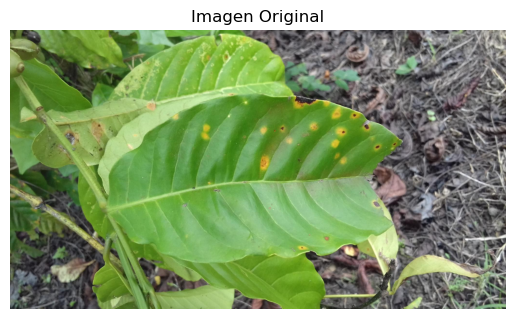

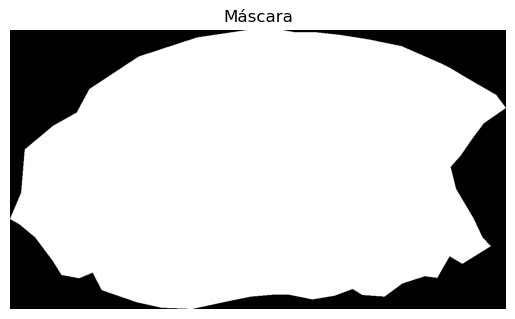

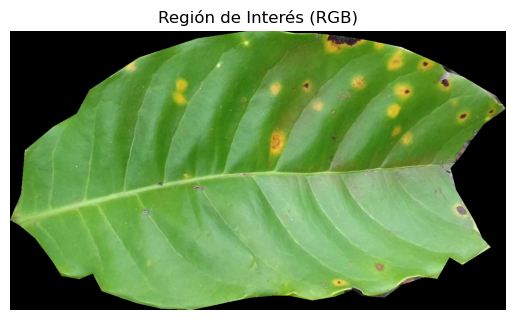

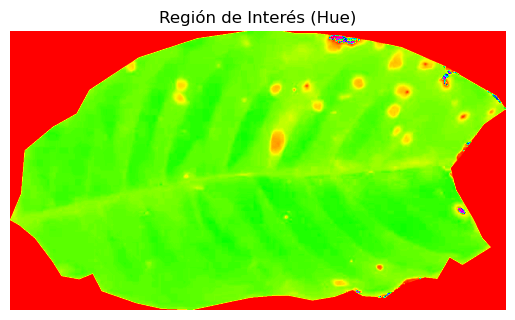

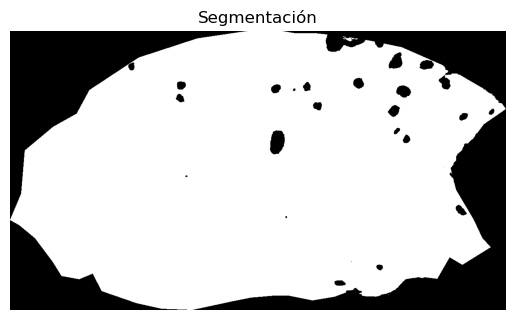

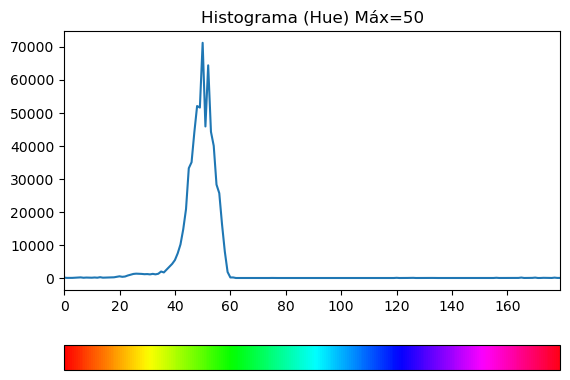

In [12]:
for coffee_leaf in coffee_leaves_class_incorrect[:5]:
    coffee_leaf.describe()